In [37]:
# ---
# ## Monthly Ekman Transport and Wind Stress Visualization
# This notebook section processes and visualizes Ekman transport (and vertical velocity)
# together with wind stress vectors over the study region.
# The plots show monthly averages for each calendar month (January–December).
# ---

# Import required libraries
import xarray as xr
import numpy as np
import calendar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define month names for labeling the subplots
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Path to the input NetCDF dataset
wind_data = '../datasets/data_t.nc'


In [7]:
# ---
# ### Function: computation()
# This function computes monthly mean fields of:
# - Ekman variable (either transport or vertical velocity)
# - Wind stress components (x and y)
#
# It takes as input:
# - `wind_data`: path to the dataset
# - `var`: the Ekman-related variable name in the dataset
#
# Returns:
# - Monthly mean wind stress components and the selected Ekman variable.
# ---

def computation(wind_data, var):
    # Load the dataset using xarray
    dat = xr.open_dataset(wind_data, engine='netcdf4')
    
    # Select latitudinal range of interest (e.g., over the coastal zone)
    dat = dat.sel(latitude=slice(2, 6))

    # Compute monthly means of the Ekman variable
    monthly_ekman = dat[var].resample(valid_time='1ME').mean()

    # Compute monthly means for wind stress components
    wind_stress_x = dat['wind_stress_x'].resample(valid_time='1ME').mean()
    wind_stress_y = dat['wind_stress_y'].resample(valid_time='1ME').mean()

    # Close dataset to free resources
    dat.close()

    # Return the three computed fields
    return wind_stress_x, wind_stress_y, monthly_ekman


In [10]:
# ---
# ### Function: plot_ekman_with_wind()
# This function creates a 4×3 grid of maps (one for each month) showing:
# - Contour plots of the Ekman-related variable (transport or vertical velocity)
# - Wind stress vectors (quivers) overlaid on each map
#
# Inputs:
# - `data_var`: tuple from computation() → (wind_stress_x, wind_stress_y, monthly_ekman)
# - `var2`: label for the Ekman variable (e.g., 'Ekman Transport')
# - `unit`: units for the variable (string)
# - `color`: matplotlib colormap name (string)
# ---

def plot_ekman_with_wind(data_var, var2, unit, color):

    # Unpack the tuple returned by computation()
    wind_stress_x, wind_stress_y, monthly_ekman = data_var

    # Create a 4x3 grid of maps using Cartopy for geographic plotting
    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()})
    contour = None  # Initialize variable for colorbar reference

    # Loop over all 12 months
    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]

        # Select and average data for the current month
        ekman_month = monthly_ekman.sel(valid_time=monthly_ekman['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')
        wind_x_month = wind_stress_x.sel(valid_time=wind_stress_x['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')
        wind_y_month = wind_stress_y.sel(valid_time=wind_stress_y['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')

        # Plot filled contours of the Ekman variable
        contour = ekman_month.plot.contourf(
            ax=ax, cmap=color, add_colorbar=False,
            levels=np.linspace(ekman_month.min(), ekman_month.max(), 20)
        )

        # Prepare wind vectors (subsampled for clarity)
        latitudes = monthly_ekman.latitude[::4]
        longitudes = monthly_ekman.longitude[::4]
        wind_x = wind_x_month.sel(latitude=latitudes, longitude=longitudes) * 100
        wind_y = wind_y_month.sel(latitude=latitudes, longitude=longitudes) * 100

        # Plot wind stress quivers on top of the contours
        ax.quiver(
            longitudes, latitudes, wind_x, wind_y,
            scale=5, scale_units='xy', width=0.003,
            color='red', transform=ccrs.PlateCarree()
        )

        # Add map details
        ax.set_title(f'{month_names[month_index]}', fontsize=12)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
        ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

    # Add a shared colorbar for all subplots
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(contour, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f'{var2} {unit}', fontsize=14)

    # Save figure to disk
    plt.savefig(f'figures/{var2}_with_wind_stress.png', dpi=300, bbox_inches='tight')

    # Display figure
    plt.show()


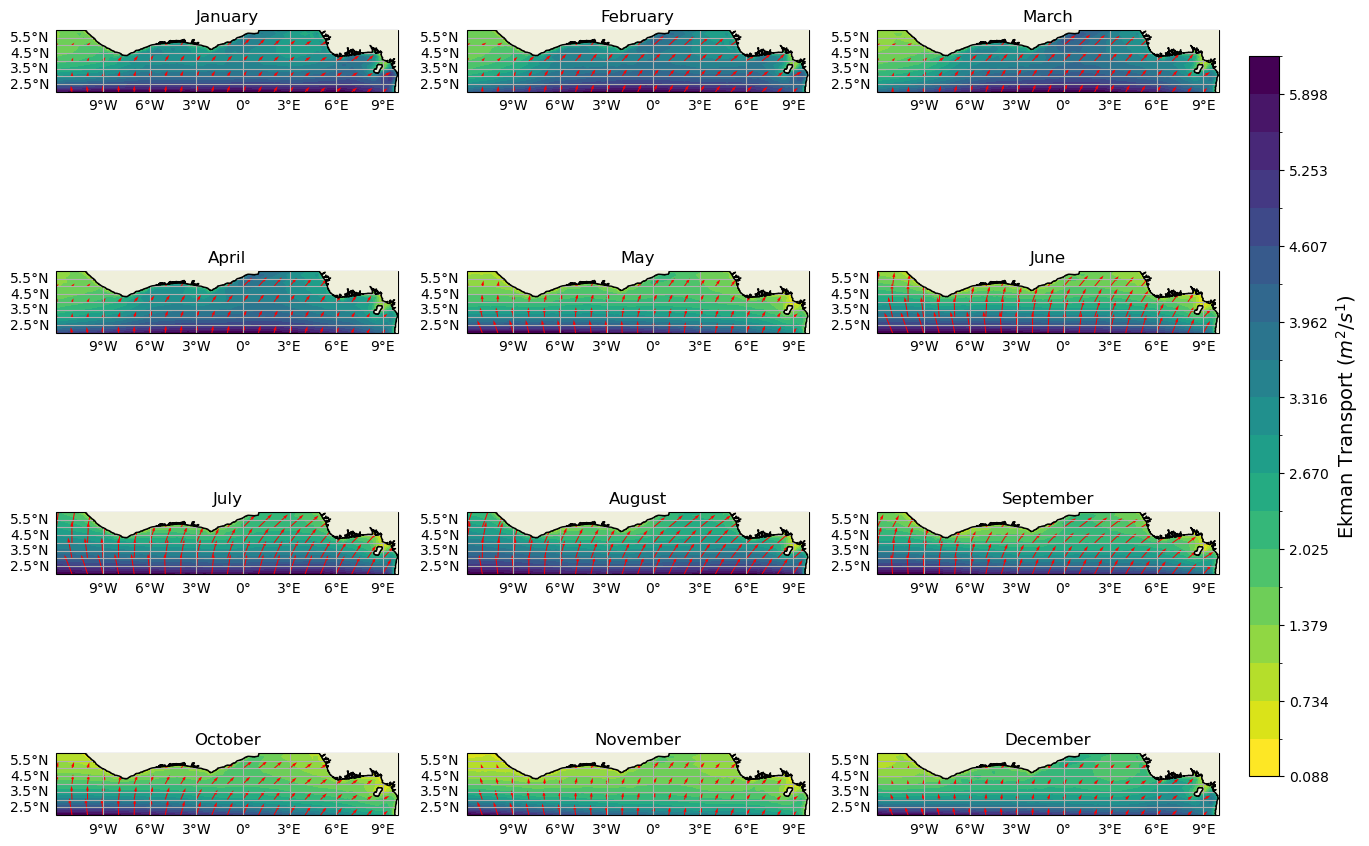

In [12]:
# ---
# ### Compute and Plot Monthly Ekman Transport
# Similarly, we compute and visualize the monthly-mean Ekman vertical velocity (m/day)
# with corresponding wind stress vectors.
# ---

ekman_T = computation(wind_data, 'ekman_transport')


plot_ekman_with_wind(ekman_T, 'Ekman Transport', f'($m^2$/$s^1$)', 'viridis_r')


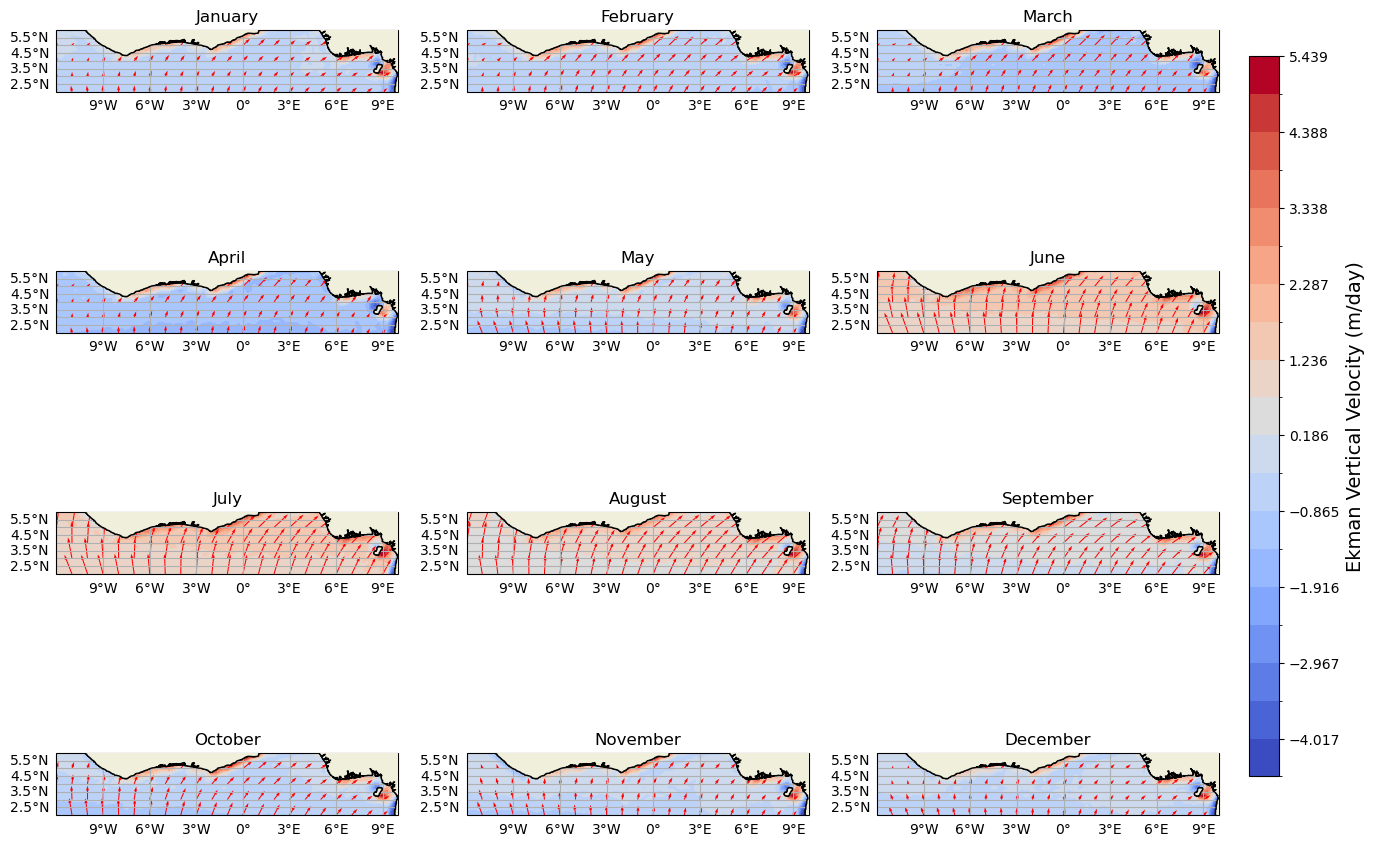

In [13]:
# ---
# ### Compute and Plot Monthly Ekman Vertical Velocity
# Similarly, we compute and visualize the monthly-mean Ekman vertical velocity (m/day)
# with corresponding wind stress vectors.
# ---

ekman_V = computation(wind_data, 'ekman_velocity_mday')

plot_ekman_with_wind(ekman_V, 'Ekman Vertical Velocity', '(m/day)', 'coolwarm')


In [14]:
# ---
# ## Monthly Sea Surface Temperature (SST) Climatology
# This section processes and visualizes monthly mean SST data from 2010–2024
# using the MUR (Multi-scale Ultra-high Resolution) dataset.
# The plots show monthly average SSTs across the study region for each calendar month.
# ---

In [16]:
# Path to the monthly SST dataset (NetCDF file)
sst_data = '../datasets/MUR_Monthly_SST_.nc'

In [18]:
# ---
# ### Function: plot_sst_data()
# This function reads, processes, and visualizes monthly mean SST.
#
# **Inputs:**
# - `dat_path`: Path to the input NetCDF file
# - `var`: Variable name in the dataset (e.g., `'sst'`)
# - `var2`: Descriptive label for the variable (e.g., `'Sea Surface Temperature'`)
# - `unit`: Unit of the variable (e.g., `'(°C)'`)
# - `color`: Colormap name for visualization (e.g., `'coolwarm'`)
#
# **Processing Steps:**
# 1. Load SST data from the NetCDF file using xarray.
# 2. Restrict the latitude domain (2°N–6.9°N) to focus on the study area.
# 3. Compute monthly means by resampling over time (`'1ME'`).
# 4. Create a 4×3 grid of subplots representing each month.
# 5. Plot SST as filled contours on a geographic map.
# 6. Add coastlines, borders, and gridlines for clarity.
# 7. Append a shared colorbar and export the final figure.
# ---

def plot_sst_data(dat_path, var, var2, unit, color):
    
    # Open the dataset using xarray
    dat = xr.open_dataset(dat_path)
    
    # Select the latitude range of interest (e.g., over the Ghanaian coast)
    dat = dat.sel(latitude=slice(2, 6.9))

    # Compute monthly mean SST (aggregated per calendar month)
    monthly_sst = dat[var].resample(time='1ME').mean()

    # Create a 4x3 grid of subplots using Cartopy for geographic maps
    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()})
    contour = None  # To store the last contour for colorbar reference

    # Loop through all 12 months (January–December)
    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]

        # Select and average SST for the given month
        sst_month = monthly_sst.sel(time=monthly_sst['time'].dt.month == (month_index + 1)).mean(dim='time')
        
        # Plot SST as filled contours
        contour = sst_month.plot.contourf(
            ax=ax, cmap=color, add_colorbar=False
        )

        # Add map features and labels
        ax.set_title(f'{month_names[month_index]}', fontsize=12)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
        ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={'bottom': 'x', 'left': 'y'})

    # Add a single colorbar for all subplots
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(contour, cax=cbar_ax, orientation='vertical', label=f'{var2} {unit}')
    
    # Adjust subplot spacing and add a main title
    plt.subplots_adjust(hspace=1.8, wspace=0.4)
    plt.suptitle(f'Monthly {var2} (2010–2024)', y=0.99, fontsize=14)

    # Save the figure to disk for later use in reports or publications
    plt.savefig(f'figures/{var2}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Close the dataset to free memory
    dat.close()


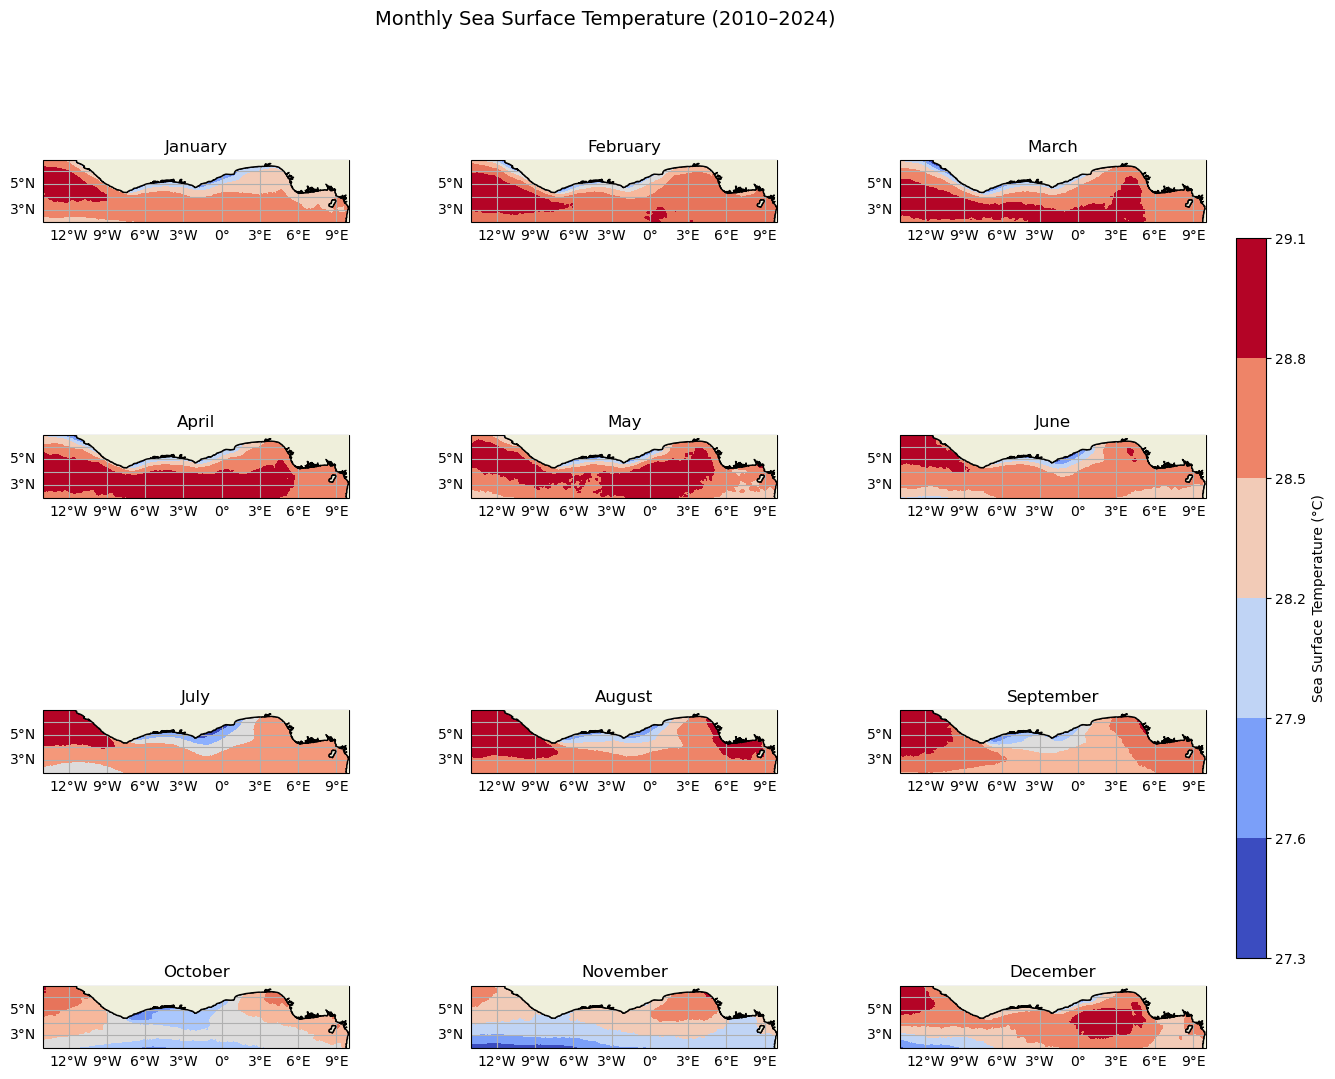

In [19]:
# ---
# ### Plot Monthly Sea Surface Temperature (SST)
# The figure below shows the mean monthly Sea Surface Temperature (°C)
# from 2010–2024 based on the MUR dataset.
# Each panel represents one month (January–December),
# illustrating the seasonal SST evolution across the study region.
# ---

plot_sst_data(sst_data, 'sst', 'Sea Surface Temperature', '(°C)', 'coolwarm')


In [20]:
# ---
# ## Monthly Sea Surface Salinity (SSS) and Sea Surface Density (SSD)
# This section visualizes the monthly mean Sea Surface Salinity (SSS)
# and Sea Surface Density (SSD) derived from CMEMS (Copernicus Marine Environment Monitoring Service)
# Level-4 monthly global products.
#
# Each 4×3 panel figure represents the spatial distribution of monthly mean SSS or SSD
# across the study region (2°–6.9°N), highlighting seasonal salinity and density variations
# along the Gulf of Guinea.
# ---


In [22]:
# Path to the CMEMS SSS & SSD dataset
sss_data = '../datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc'

In [23]:
# ---
# ### Function: plot_sss()
# This function visualizes the monthly climatology of Sea Surface Salinity (SSS)
# or Sea Surface Density (SSD) from the CMEMS dataset.
#
# **Inputs:**
# - `sss_data`: Path to the CMEMS dataset (NetCDF format)
# - `var0`: Variable name for salinity (e.g., `'sos'`)
# - `var1`: Variable name for density (e.g., `'dos'`)
# - `var3`: Descriptive title for the plot (e.g., `'Sea Surface Salinity'`)
# - `unit`: Unit for the variable (e.g., `'psu'` for salinity or `'kg/m³'` for density)
# - `color`: Colormap name (e.g., `'viridis'`, `'coolwarm'`, `'plasma'`)
#
# **Processing Steps:**
# 1. Load and subset the dataset for latitude (2°–6.9°N) and surface depth (0 m).
# 2. Compute monthly means for both salinity and density.
# 3. Generate 12 subplots (January–December).
# 4. Plot filled contours for SSS or SSD and overlay labeled contour lines.
# 5. Add coastlines, political boundaries, and a shared vertical colorbar.
# 6. Save the output figure.
# ---

def plot_sss(sss_data, var0, var1, var3, unit, color):
    # Open the dataset using xarray
    data_1 = xr.open_dataset(sss_data)

    # Select the latitude band and surface layer (depth = 0)
    data_1 = data_1.sel(latitude=slice(2, 6.9))
    data_1 = data_1.sel(depth=0)

    # Compute monthly means for salinity and density
    monthly_sss = data_1[var0].resample(time='1ME').mean()
    monthly_dos = data_1[var1].resample(time='1ME').mean()

    # Create a 4×3 grid of subplots using Cartopy
    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3,
                            subplot_kw={"projection": ccrs.PlateCarree()})

    # Loop over all 12 months
    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]

        # Select SSS data for the current month
        sss_month = monthly_sss.sel(time=monthly_sss['time'].dt.month == (month_index + 1))

        # Ensure data is 2D by averaging over time if necessary
        if 'time' in sss_month.dims:
            sss_month_2d = sss_month.mean(dim='time')
        else:
            sss_month_2d = sss_month

        # Plot filled contours for SSS or SSD
        contour = sss_month_2d.plot(ax=ax, cmap=color, add_colorbar=False)

        # Add contour lines to emphasize key value ranges (adjust as needed)
        contour_lines = ax.contour(
            sss_month_2d.longitude,
            sss_month_2d.latitude,
            sss_month_2d,
            levels=[35.0, 35.1, 35.2],  # Salinity levels; adjust for density if needed
            colors='black',
            linewidths=2
        )

        # Label the contour lines
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='%0.2f')

        # Add map features
        ax.set_title(f'{month_names[month_index]}', fontsize=12)
        ax.coastlines(resolution='50m', color='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
        ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

    # Add a shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(contour, cax=cbar_ax, orientation='vertical', label=f'{var3} {unit}')

    # Add a main title and save figure
    plt.suptitle(f'Monthly {var3}', y=0.9, fontsize=14)
    plt.savefig(f'figures/{var3}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Close dataset to free memory
    data_1.close()



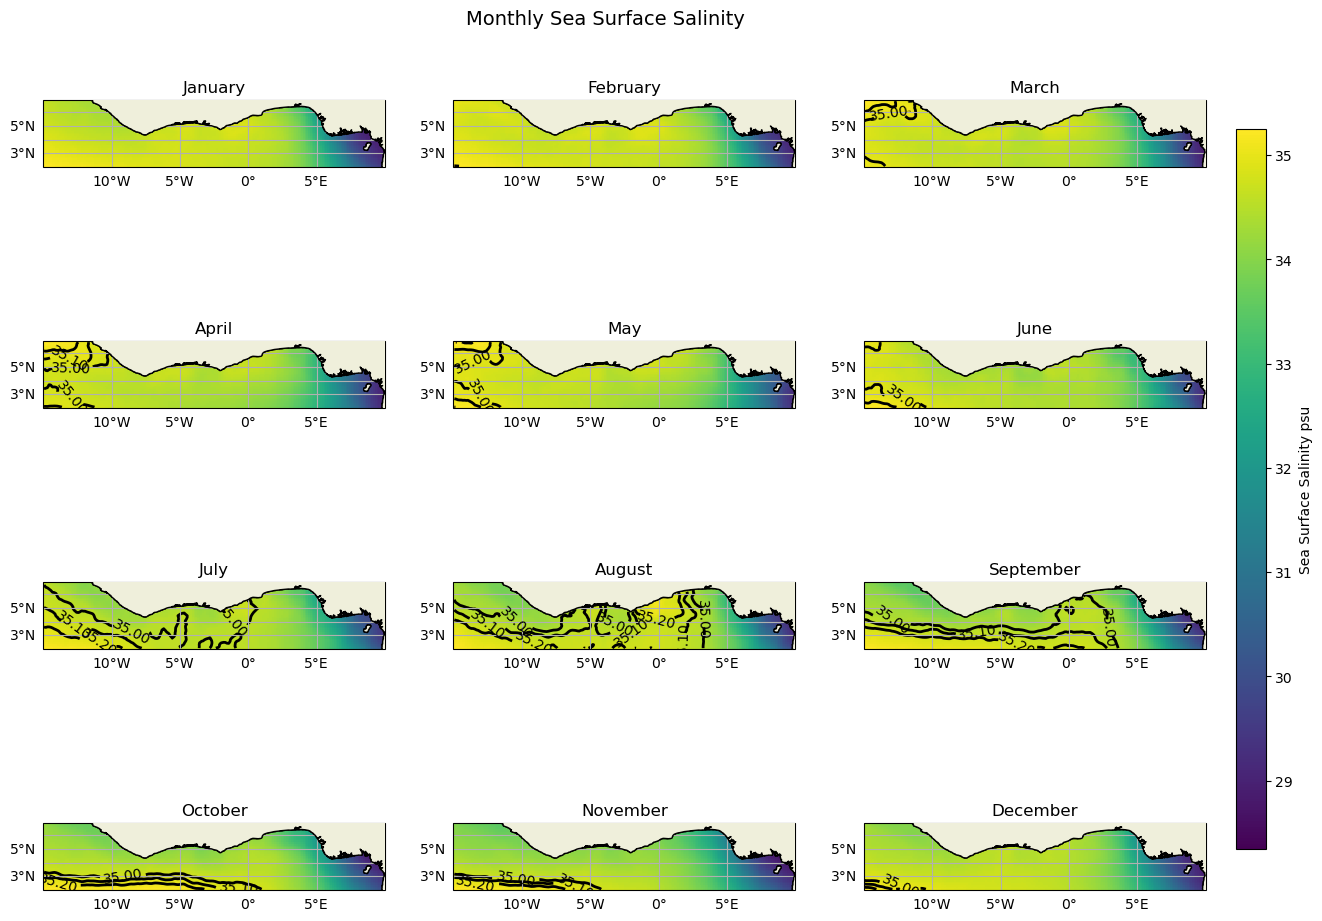

In [24]:
# ---
# ### Plot Monthly Sea Surface Salinity (SSS)
# The plot below shows the monthly mean Sea Surface Salinity (psu)
# averaged from the CMEMS dataset, highlighting the seasonal variations
# in surface salinity along the Gulf of Guinea.
# ---

plot_sss(sss_data, 'sos', 'dos', 'Sea Surface Salinity', 'psu', 'viridis')


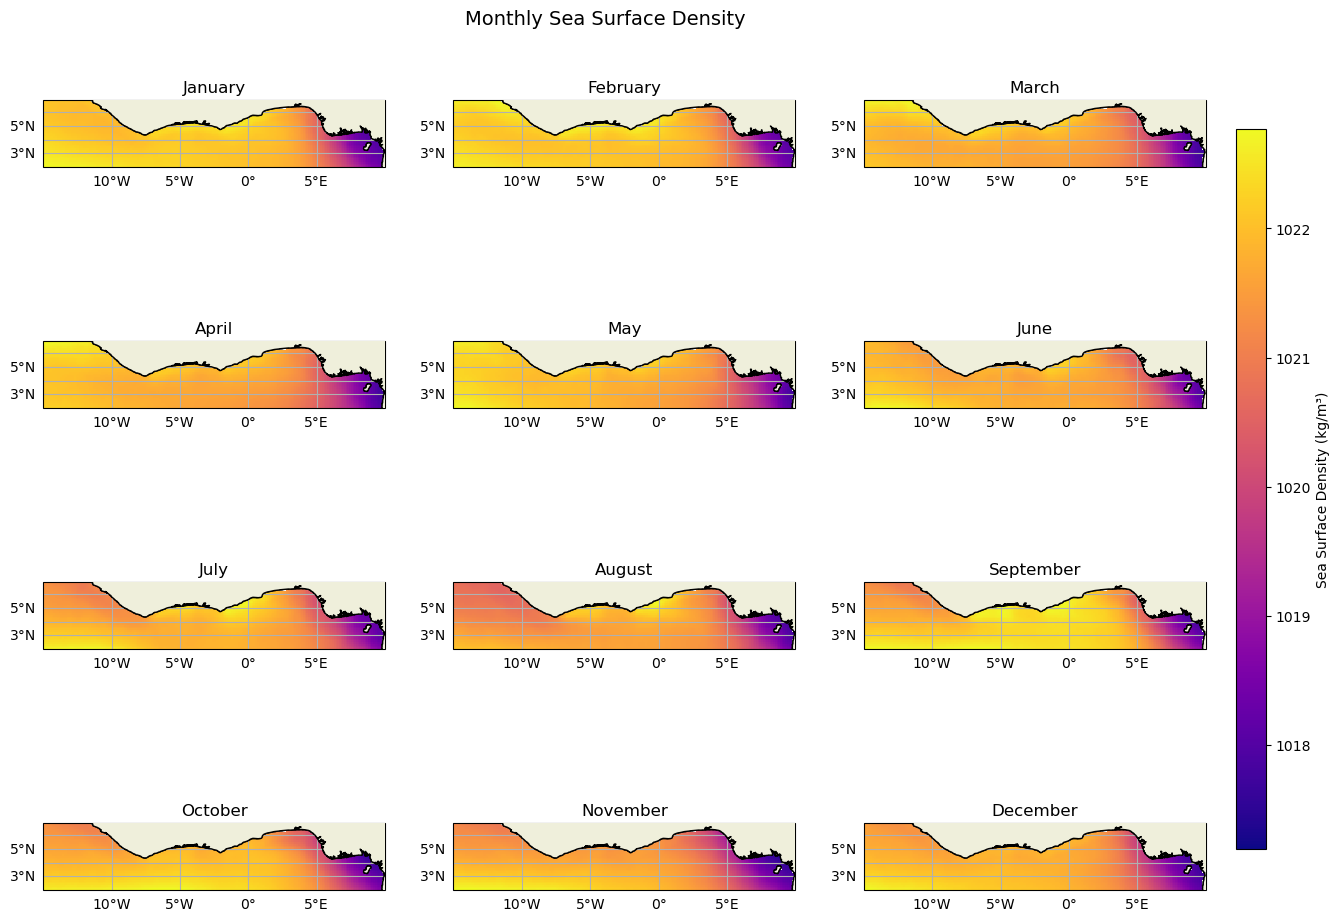

In [25]:
# ---
# ### Plot Monthly Sea Surface Density (SSD)
# The same function can be reused to visualize Sea Surface Density (SSD)
# by switching the descriptive label and unit.
# ---

plot_sss(sss_data, 'dos', 'sos', 'Sea Surface Density', r'(kg/m³)', 'plasma')


In [26]:
# ============================================================
# Monthly Sea Surface Height (SSH) Visualization
# ------------------------------------------------------------
# This script plots monthly mean Sea Surface Height (SSH)
# over the Gulf of Guinea region (latitude 2°–6.9°N) using 
# satellite Level-4 gridded data.
#
# Features:
#  - 12 subplots (one per month)
#  - Smooth monthly mean maps
#  - Contour overlays for selected SSH levels
#  - Coastlines, borders, and gridlines for geographic context
#  - Shared vertical colorbar
# ============================================================

In [32]:
# ------------------------------------------------------------
# Dataset path (Sea Surface Height)
# ------------------------------------------------------------
ssh_data = '../datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
current_data = '../datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'

In [33]:

def plot_ssh(dat_path_1, dat_path_2, depth_level, var0, var1, var2, var3, unit, color):
    """
    Plots 12 monthly mean maps of Sea Surface Height (SSH) 
    using CMEMS (Copernicus Marine Environment Monitoring Service) data.

    Parameters
    ----------
    ssh_data : str
        File path to the NetCDF SSH dataset.
    var0 : str
        SSH variable name (e.g., 'adt' for Absolute Dynamic Topography).
    var3 : str
        Full variable description for labeling (e.g., 'Sea Surface Height').
    unit : str
        Unit of measurement (e.g., 'm').
    color : str
        Matplotlib colormap (e.g., 'viridis', 'coolwarm').
    """
    
    # Open the datasets
    data_1 = xr.open_dataset(dat_path_1)
    data_1 = data_1.sel(latitude=slice(2, 6.9))
    data_2 = xr.open_dataset(dat_path_2)
    data_2 = data_2.sel(latitude=slice(2, 6.9))

    # Resample SSH data and geostrophic currents
    monthly_ssh = data_1[var0].resample(time='1ME').mean()
    ds_depth = data_2.sel(depth=depth_level)
    ugos = ds_depth[var1].resample(time='1ME').mean()  # Eastward surface geostrophic current
    vgos = ds_depth[var2].resample(time='1ME').mean()  # Northward surface geostrophic current
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()})
    
    # Looping through each month
    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]

        # Select SSH data for the current month
        ssh_month = monthly_ssh.sel(time=monthly_ssh['time'].dt.month == (month_index + 1))

        # Reducing the dimensions to 2D (latitude, longitude) by averaging over the time dimension
        ssh_month_2d = ssh_month.mean(dim='time')

        # Plotting the SSH contours
        contour = ssh_month_2d.plot(ax=ax, cmap=color, add_colorbar=False)
        
        contour_lines = ax.contour(ssh_month_2d.longitude, ssh_month_2d.latitude, ssh_month_2d, levels=[0.375, 0.425], colors='black', linewidths=2)

        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='%0.2f')  
        

        latitudes = ugos.latitude[::5]  
        longitudes = ugos.longitude[::5] 
        
        ugos_selected = ugos.sel(longitude=longitudes, latitude=latitudes).mean(dim='time')  
        vgos_selected = vgos.sel(longitude=longitudes, latitude=latitudes).mean(dim='time')  
        
        # Plotting the geostrophic current vectors
        # ax.quiver(longitudes, latitudes, ugos_selected, vgos_selected, scale=5, color='red', width=0.003)

        ax.set_title(f'{month_names[month_index]}', fontsize=12)
        ax.coastlines(resolution='50m', color='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')  
        ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')  
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  
    fig.colorbar(contour, cax=cbar_ax, orientation='vertical', label=f'{var3} {unit}')
    
    plt.suptitle(f'Monthly {var3}', y=0.9, fontsize=14)
    
    plt.savefig(f'figures/{var3}.png')
    plt.show()

    data_1.close()
    data_2.close()




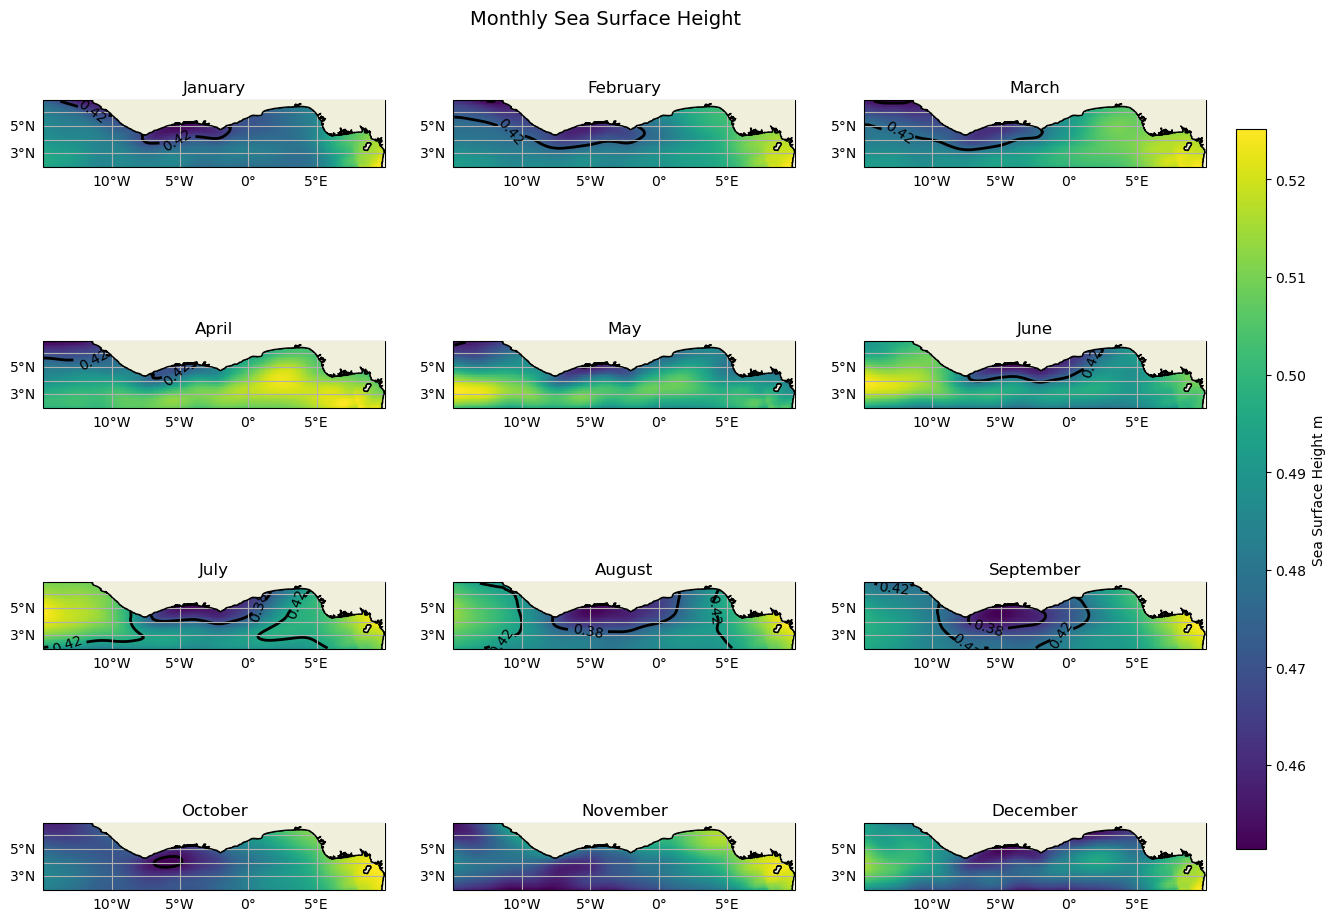

In [34]:
# Example call
plot_ssh(ssh_data, current_data, 15, 'adt', 'ugos', 'vgos', 'Sea Surface Height',  'm', 'viridis')

In [44]:
# ============================================================
# Signatures of Coastal Upwelling in the Gulf of Guinea
# ============================================================
# This script visualizes the longitudinal-monthly structure of 
# Sea Surface Temperature (SST), Sea Surface Height (SSH),
# Sea Surface Salinity (SSS), and Sea Surface Density (SSD)
# along the coastal region of the northern Gulf of Guinea.
#
# The plots highlight seasonal variations and upwelling signatures
# along the coast between Cape Palmas (-7.7°) and Cape Three Points (-2.1°).
# ============================================================

In [42]:
# ------------------------------------------------------------
# Dataset paths
# ------------------------------------------------------------
ssh_data = '../datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
sst_data = '../datasets/MUR_Monthly_SST_.nc'
sss_data = '../datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc'


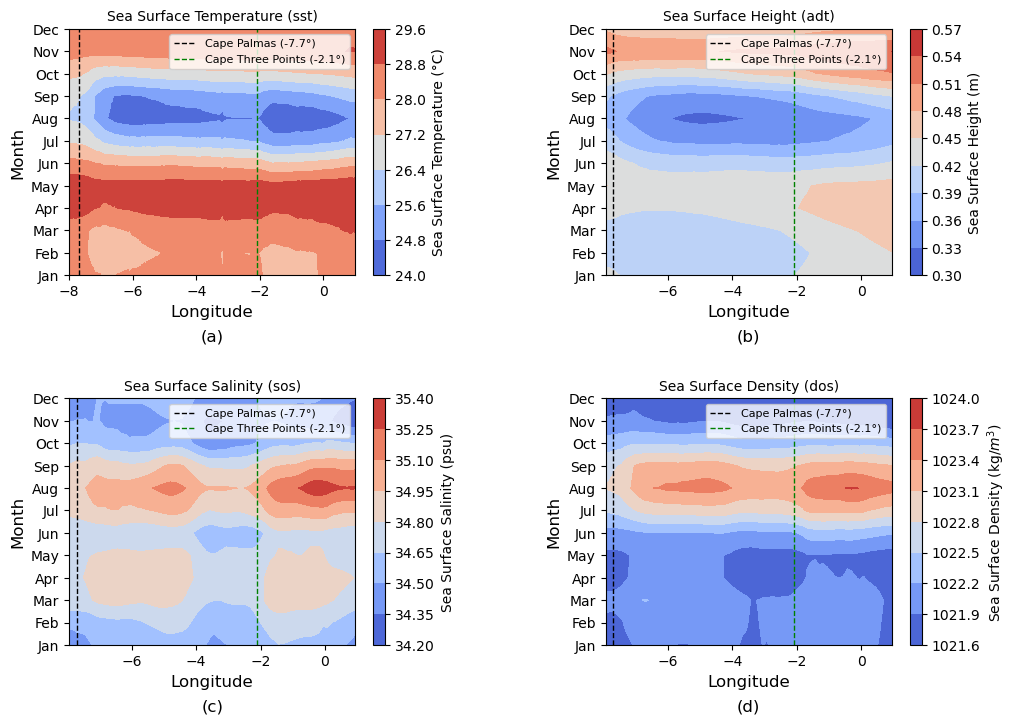

In [43]:
# ------------------------------------------------------------
# Load and subset datasets to study region
# ------------------------------------------------------------
sss_data = xr.open_dataset(sss_data)
ssh_data = xr.open_dataset(ssh_data)
sst_data = xr.open_dataset(sst_data)

# Focused domain along the northern Gulf of Guinea coast
dar1 = sss_data.sel(longitude=slice(-8, 1), latitude=slice(4, 6), depth=0)
dar2 = ssh_data.sel(longitude=slice(-8, 1), latitude=slice(4, 6))
dar3 = sst_data.sel(longitude=slice(-8, 1), latitude=slice(4, 6))

# ------------------------------------------------------------
# Compute monthly means averaged over latitude and time
# ------------------------------------------------------------
sss = dar1.groupby('time.month').mean(['latitude', 'time'])
ssh = dar2.groupby('time.month').mean(['latitude', 'time'])
sst = dar3.groupby('time.month').mean(['latitude', 'time'])

# ------------------------------------------------------------
# Reference longitudes for upwelling centers
# ------------------------------------------------------------
cape_palmas_lon = -7.7
cape_three_points_lon = -2.1

# ------------------------------------------------------------
# Prepare figure and plotting structure
# ------------------------------------------------------------
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
plt.subplots_adjust(right=0.87, wspace=0.5, hspace=0.5)

# Units and variable metadata
density_unit = f'(kg/$m^3$)'

# Dataset-variable mappings
datasets = [
    (sst, 'sst'),    # Sea Surface Temperature
    (ssh, 'adt'),    # Sea Surface Height
    (sss, 'sos'),    # Sea Surface Salinity
    (sss, 'dos')     # Sea Surface Density
]

titles = [
    "Sea Surface Temperature (sst)",
    "Sea Surface Height (adt)",
    "Sea Surface Salinity (sos)",
    "Sea Surface Density (dos)"
]

labs = [
    "Sea Surface Temperature (°C)",
    "Sea Surface Height (m)",
    "Sea Surface Salinity (psu)",
    f"Sea Surface Density {density_unit}"
]

labels = ['(a)', '(b)', '(c)', '(d)']

# ------------------------------------------------------------
# Plot each variable as longitude–month cross-sections
# ------------------------------------------------------------
for i, ((data, var), title, lab, ax) in enumerate(zip(datasets, titles, labs, axes.flat)):
    lon_coords = data[var].longitude.values
    month_coords = np.arange(1, 13)
    
    # Filled contour plot
    cf = ax.contourf(lon_coords, month_coords, data[var].values, cmap='coolwarm')
    plt.colorbar(cf, ax=ax, label=f'{lab}')

    # Title and axis labels
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Month', fontsize=12)

    # Format y-axis with abbreviated month names
    ax.set_yticks(range(1, 13))
    ax.set_yticklabels(calendar.month_abbr[1:13])

    # Add vertical reference lines for upwelling capes
    ax.axvline(x=cape_palmas_lon, color='black', linestyle='--', linewidth=1, label='Cape Palmas (-7.7°)')
    ax.axvline(x=cape_three_points_lon, color='green', linestyle='--', linewidth=1, label='Cape Three Points (-2.1°)')
    ax.legend(loc='upper right', fontsize=8)

    # Add subplot label below each subplot
    ax.text(0.5, -0.25, labels[i], transform=ax.transAxes,
            fontsize=12, ha='center', va='center')

# ------------------------------------------------------------
# Save and display figure
# ------------------------------------------------------------
plt.savefig('figures/signatures_of_coastal_upwelling.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
def homvoller_plot(data):
    open_data = xr.open_dataset(f"{data}")

    open_data = open_data.sel(latitude=slice(2,6))
    grouped_data = open_data.groupby('valid_time.month').mean(['longitude','valid_time'])

    # plotting
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,7))
    # plt.subplots_adjust(right=0.87, wspace=0.5, hspace=0.5)
    plt.subplots_adjust(right=0.87, wspace=0.5, hspace=0.5, bottom=0.15)


    # Plot Ekman vertical velocity
    grouped_data['ekman_velocity_mday'].plot.contourf(
        y='latitude', zorder=100, ax=axes[0], cmap='coolwarm'
    )
    axes[0].set_title('Ekman Vertical Velocity', fontsize=12)
    
    # Plot Ekman transport
    grouped_data['ekman_transport'].plot.contourf(
        y='latitude', zorder=100, ax=axes[1], cmap='coolwarm'
    )
    axes[1].set_title('Ekman Transport', fontsize=12)

    # Set month names on x-axis
    month_names = [calendar.month_abbr[m] for m in range(1, 13)]  # ['Jan', 'Feb', ..., 'Dec']
    for ax in axes:
        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(month_names, rotation=45, ha='right')


    #plt.suptitle('Hovmöller Plot of Ekman Drivers (2°-6°N)', fontsize=10)
    plt.savefig("figures/Hovmoller_plot.png", dpi=100)
    plt.show()

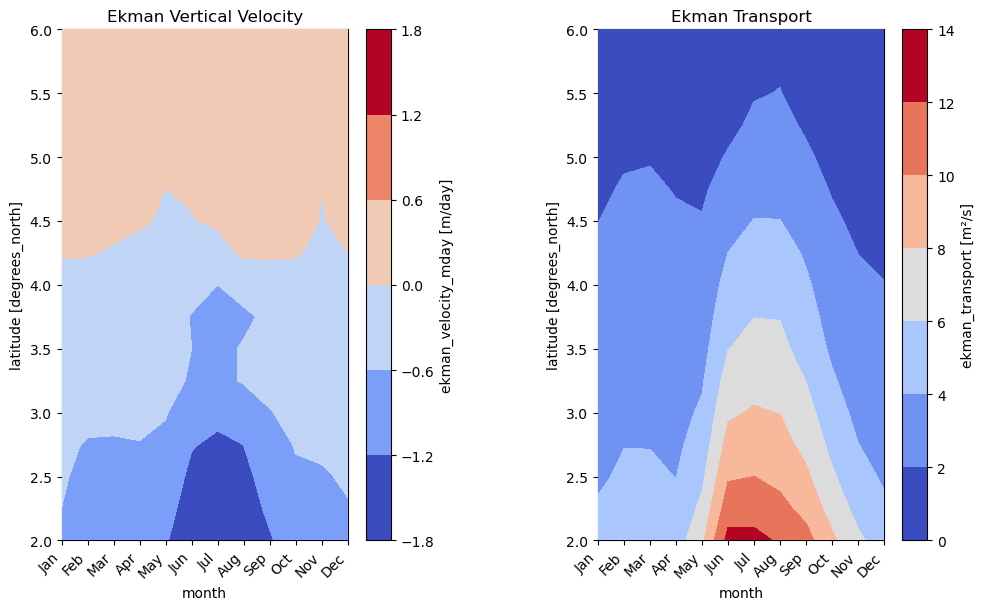

In [46]:
homvoller_plot(f"{wind_data}")